# Imports

In [153]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools    import jarque_bera
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import yeojohnson, yeojohnson_normmax
from scipy.stats.mstats import winsorize

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

from pmdarima import auto_arima
from arch import arch_model

from xgboost import XGBRegressor
import shap

import joblib
from joblib import Parallel, delayed, parallel_backend

from tqdm import tqdm

# Global Settings & Functions

In [154]:
cv_window = 60  # Initial window for cross-validation
cv_step = 30    # Step size for cross-validation

warnings.filterwarnings('ignore')

In [155]:
def winsorize_yj(
    series: pd.Series,
    limits: tuple = (0.01, 0.01)
) -> tuple[np.ndarray, dict]:
    """
    Winsorizes the series, shifts it to be strictly positive, 
    and applies the Yeo-Johnson transformation.

    Parameters
    ----------
    series : pd.Series
        Input time series to transform.
    limits : tuple, default (0.01, 0.01)
        Tuple specifying the lower and upper percentile limits 
        for winsorization.

    Returns
    -------
    transformed : np.ndarray
        Transformed series after winsorization, shift, and Yeo-Johnson transform.
    params : dict
        Dictionary containing the transformation parameters:
        - 'lambda': Optimal lambda for the Yeo-Johnson transformation.
        - 'shift': Amount added to shift data to strictly positive.
    """
    w = winsorize(series.values, limits=limits)  # Winsorize outliers
    s_w = pd.Series(w, index=series.index)

    shift = -s_w.min() + 1e-6  # Ensure data is strictly positive
    shifted = s_w + shift

    lam = yeojohnson_normmax(shifted)  # Find optimal lambda
    transformed = yeojohnson(shifted, lmbda=lam)

    return transformed, {"lambda": lam, "shift": shift}

In [156]:
def inv_yj(arr: np.ndarray, params: dict) -> np.ndarray:
    """
    Applies the inverse of the Yeo-Johnson transformation.

    Parameters
    ----------
    arr : np.ndarray
        Transformed array to invert.
    params : dict
        Dictionary containing transformation parameters:
        - 'lambda': Lambda used during the forward transformation.
        - 'shift': Shift applied before transformation.

    Returns
    -------
    y : np.ndarray
        Original array, inverse-transformed and unshifted.
    """
    lam = params["lambda"]
    sh = params["shift"]

    x = np.asarray(arr, dtype=float)
    y = np.zeros_like(x)

    # Positive branch of the inverse
    pos = x >= 0
    if lam != 0:
        y[pos] = np.power(x[pos] * lam + 1, 1 / lam) - 1
    else:
        y[pos] = np.exp(x[pos]) - 1

    # Negative branch of the inverse
    neg = x < 0
    if lam != 2:
        y[neg] = 1 - np.power(-x[neg] * (2 - lam) + 1, 1 / (2 - lam))
    else:
        y[neg] = 1 - np.exp(-x[neg])

    return y - sh

# Data Loading & Visualisation

### Data Loading

In [157]:
# Load the data
etf_data = pd.read_excel('../data/etf_data_2.xlsx', 
                    index_col=0, parse_dates=True)
macro = pd.read_excel('../data/macro_data.xlsx', 
                      index_col=0, parse_dates=True)

# Convert Tracking Error to basis points
etf_data['Tracking_Error'] = etf_data['Tracking_Error']*10000       

# Check the data
display(etf_data.head())
display(macro.head())

,ETF_Ticker,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,...,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Fund_Family,Fund_Category,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings,Optionable,Shortable
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,SPY,82.933676,83.070128,79.392844,80.614067,1184211500,-0.022420,-0.025290,0.006447,28.70,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-02-01,SPY,80.675479,83.008700,80.573141,82.299217,1025608400,0.020904,0.018903,0.006730,20.01,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-03-01,SPY,82.428789,84.086674,79.622477,80.793709,1330548800,-0.018293,-0.019118,0.006339,8.25,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-04-01,SPY,81.252579,81.684066,77.773181,79.280006,1633318500,-0.018735,-0.020109,0.009503,13.73,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-05-01,SPY,79.499193,82.362160,78.629339,81.834778,1334647300,0.032225,0.029952,0.006390,22.73,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True


,vix,michigan_consumer_sentiment_index
2005-01-01,12.82,95.5
2005-02-01,12.08,94.1
2005-03-01,14.02,92.6
2005-04-01,15.31,87.7
2005-05-01,13.29,86.9


In [158]:
# Get information about the data
print("ETF Data Info:")
display(etf_data.describe())
print("\nMacro Data Info:")
display(macro.describe())

ETF Data Info:


,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,Net_Assets_USD,NAV_USD,PE_Ratio,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings
count,7176.000000,7176.000000,7176.000000,7176.000000,7.176000e+03,7176.000000,7176.000000,7176.000000,7176.000000,7.176000e+03,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176,7176.000000,7176.000000
mean,86.766325,90.172714,83.285888,87.422013,3.038787e+08,0.009043,0.007561,0.011833,14.823686,1.411339e+11,230.974559,24.443200,144.618729,1.008428,16.770903,2000-03-15 16:27:17.458193920,0.004031,634.692308
min,4.405518,5.344535,3.543700,4.580290,3.784000e+05,-0.343710,-0.351986,0.001958,-1063.270000,7.002211e+08,51.012780,15.364081,45.000000,0.550000,3.000000,1993-01-22 00:00:00,0.000286,26.000000
25%,29.221763,30.469714,27.823003,29.566423,1.965720e+07,-0.019093,-0.020340,0.007127,2.617500,1.106325e+10,83.582250,20.007551,110.000000,0.980000,8.000000,1998-12-16 00:00:00,0.001727,50.000000
50%,54.945025,57.069586,52.716665,55.417520,7.013130e+07,0.013325,0.011668,0.009758,13.445000,2.627259e+10,155.905620,23.717783,129.000000,1.030000,16.000000,2000-05-22 00:00:00,0.005014,391.000000
75%,105.872270,108.983108,102.154641,106.245455,2.217607e+08,0.039673,0.038243,0.013736,25.905000,7.217285e+10,329.669600,27.027494,186.000000,1.120000,21.000000,2000-06-12 00:00:00,0.005802,1022.000000
max,610.746536,618.325438,580.050265,610.132324,1.188235e+10,0.307639,0.296553,0.086460,1520.780000,1.822973e+12,602.602500,38.760517,350.000000,1.470000,39.000000,2011-12-20 00:00:00,0.007566,3559.000000
std,89.140964,92.579945,85.819490,89.985562,7.213975e+08,0.052470,0.053142,0.008136,65.798246,3.467729e+11,169.373865,5.924201,68.635454,0.205274,10.588061,NaN,0.002339,840.145388



Macro Data Info:


,vix,michigan_consumer_sentiment_index
count,240.000000,240.000000
mean,19.299542,80.122083
std,8.250237,12.798809
min,9.510000,50.000000
25%,13.535000,70.450000
50%,16.810000,80.200000
75%,22.990000,91.550000
max,59.889999,101.400000


### Plots

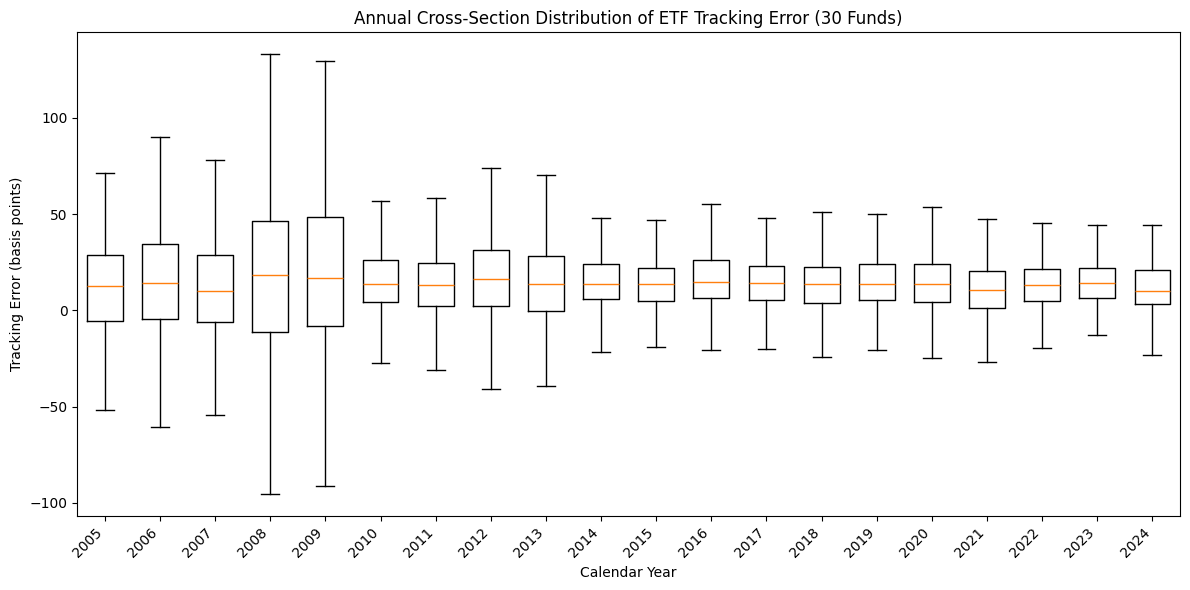

In [161]:
# Gather the Tracking Error (TE) values for each calendar year
ys_lists_bp = (
    etf_data
        .groupby(etf_data.index.year)['Tracking_Error']
        .apply(lambda x: (x * 1).tolist())  
)

# Create the strip of yearly box plots showing cross-sectional TE distribution
fig, ax = plt.subplots(figsize=(12, 6))

positions = range(len(ys_lists_bp))  # X-axis positions for each year's box plot
ax.boxplot(
    ys_lists_bp.tolist(),   # List of lists of TE values per year
    positions=positions,    # Set positions explicitly to match year order
    widths=0.65,
    showfliers=False        # Toggle to True to display individual outlier dots
)

# Set x-axis tick labels to corresponding calendar years
ax.set_xticks(positions)
ax.set_xticklabels([str(y) for y in ys_lists_bp.index], rotation=45, ha='right')

# Title and axis labels
ax.set_title("Annual Cross-Section Distribution of ETF Tracking Error (30 Funds)")
ax.set_xlabel("Calendar Year")
ax.set_ylabel("Tracking Error (basis points)")

plt.tight_layout()
plt.show()

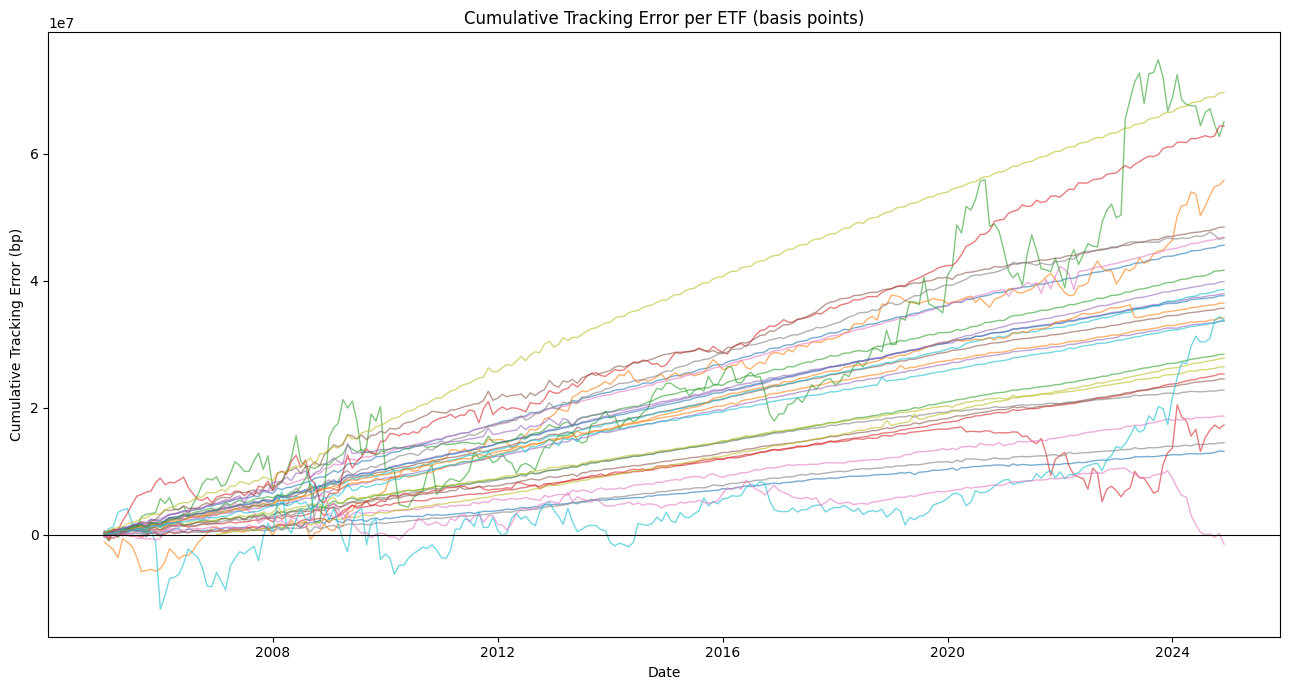

In [162]:
cum_te_df = etf_data.copy()

# Convert tracking error from decimal to basis points (e.g. 0.002 → 20 bp)
cum_te_df['TE_bp'] = cum_te_df['Tracking_Error'] * 10_000

# Compute running cumulative tracking error (bp) within each ETF
cum_te_df = cum_te_df.sort_values(['ETF_Ticker', 'Date'])
cum_te_df['Cum_TE_bp'] = cum_te_df.groupby('ETF_Ticker')['TE_bp'].cumsum()

# Reshape from long to wide format (keep last record if duplicates on same date)
wide = (
    cum_te_df.pivot_table(index='Date',
                   columns='ETF_Ticker',
                   values='Cum_TE_bp',
                   aggfunc='last')
      .sort_index()
)

# Plot one semi-transparent line per ETF
plt.figure(figsize=(13, 7))
for col in wide.columns:
    plt.plot(wide.index, wide[col], linewidth=1, alpha=0.6)

plt.axhline(0, color='black', linewidth=0.8)
plt.title('Cumulative Tracking Error per ETF (basis points)')
plt.xlabel('Date')
plt.ylabel('Cumulative Tracking Error (bp)')
plt.tight_layout()
plt.show()

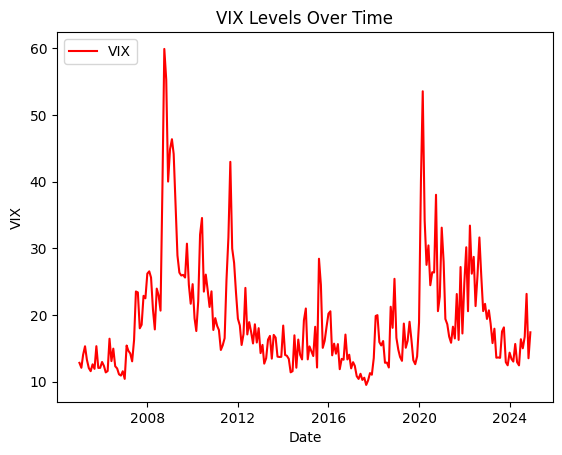

In [163]:
# VIX 
fig, ax1 = plt.subplots()
ax1.plot(macro['vix'], label='VIX', color='r')
ax1.set_xlabel('Date'); ax1.set_ylabel('VIX')

lines1, labs1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labs1, loc='upper left')
plt.title('VIX Levels Over Time')
plt.show()

# SARIMA-GARCH Model Fitting

### SARIMA-GARCH Base Model

In [164]:
def fit_sarima_garch(
    series: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    forecast_plot: bool = True,
) -> dict:
    """
    Fits a SARIMA model with expanding-window cross-validation, and
    optionally visualizes the final CV fold with GARCH-based 95% confidence intervals.

    Parameters
    ----------
    series : pd.Series
        Time series to model.
    horizon : int
        Forecast horizon (steps ahead).
    cv_window : int
        Initial training window for expanding-window CV.
    cv_step : int
        Step size between CV folds.
    winsor_limits : tuple
        Winsorization limits for outlier treatment.
    seasonal_period : int
        Seasonal period for SARIMA.
    n_jobs : int
        Number of parallel jobs for CV folds.
    arima_jobs : int
        Number of parallel jobs inside each auto_arima fit.
    max_pq : int
        Maximum AR/MA and SAR/SMA order.
    max_dD : int
        Maximum differencing order (regular and seasonal).
    forecast_plot : bool
        If True, plots final CV fold forecast with GARCH 95% CI.

    Returns
    -------
    dict
        Dictionary containing:
        - 'cv_metrics': Cross-validation performance metrics (MAE, MSE, R2).
        - 'forecast_df': DataFrame of forecasts vs actuals for all folds.
    """

    # ─────────────────────────────────────────────────────────────
    # 0. Data Preparation And Window Setup
    # ─────────────────────────────────────────────────────────────
    y = series.dropna()
    if len(y) < cv_window + horizon:
        raise ValueError("Series too short for chosen cv_window + horizon.")

    fold_ends = list(range(cv_window, len(y) - horizon + 1, cv_step))
    if fold_ends[-1] != len(y) - horizon:
        fold_ends.append(len(y) - horizon)

    # ─────────────────────────────────────────────────────────────
    # 1. Cross-Validation Fold Worker
    # ─────────────────────────────────────────────────────────────
    def _cv_fold(end: int) -> tuple[float, float, float, pd.DataFrame]:
        """
        Perform a single CV fold: fit SARIMA, forecast, and evaluate.

        Parameters
        ----------
        end : int
            Index in the time series at which the training window ends.

        Returns
        -------
        tuple
            Tuple of (MAE, MSE, R2, forecast DataFrame) for this fold.
        """
        train = y.iloc[:end]
        test = y.iloc[end:end + horizon]

        # Winsorize and transform the training data
        tr_t, tf_par = winsorize_yj(train, winsor_limits)

        # Fit SARIMA model to transformed series
        model = auto_arima(
            tr_t,
            seasonal=True,
            m=seasonal_period,
            information_criterion="aic",
            max_p=max_pq,
            max_q=max_pq,
            max_d=max_dD,
            max_P=max_pq,
            max_Q=max_pq,
            max_D=max_dD,
            stepwise=True,
            maxiter=20,
            suppress_warnings=True,
            error_action="ignore",
            n_jobs=arima_jobs,
        )

        # Forecast and inverse-transform to original scale
        forecast = inv_yj(model.predict(horizon), tf_par)

        # Collect forecast and actuals in DataFrame for diagnostics
        fc_df = pd.DataFrame({
            "Date": test.index,
            "Forecast": forecast,
            "Actual": test.values,
            "horizon": horizon
        })

        return (
            mean_absolute_error(test, forecast),
            mean_squared_error(test, forecast),
            r2_score(test, forecast),
            fc_df
        )

    # ─────────────────────────────────────────────────────────────
    # 2. Execute Cross-Validation Folds In Parallel
    # ─────────────────────────────────────────────────────────────
    res_list = Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends)
    mae, mse, r2, fc_dfs = zip(*res_list)

    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": list(mae), "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": list(mse), "mean": np.mean(mse), "std": np.std(mse)},
        "R2": {"values": list(r2), "mean": np.mean(r2), "std": np.std(r2)},
    }

    forecast_df = pd.concat(fc_dfs, ignore_index=True)

    # ─────────────────────────────────────────────────────────────
    # 3. Plot Final Fold Forecast With GARCH Confidence Intervals
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        end = fold_ends[-1]
        train = y.iloc[:end]
        test = y.iloc[end:end + horizon]

        tr_t, tf_par = winsorize_yj(train, winsor_limits)
        model = auto_arima(
            tr_t,
            seasonal=True,
            m=seasonal_period,
            information_criterion="aic",
            max_p=max_pq,
            max_q=max_pq,
            max_d=max_dD,
            max_P=max_pq,
            max_Q=max_pq,
            max_D=max_dD,
            stepwise=True,
            maxiter=20,
            suppress_warnings=True,
            error_action="ignore",
            n_jobs=arima_jobs,
        )

        fc = inv_yj(model.predict(horizon), tf_par)

        # Estimate forecast uncertainty using GARCH(1,1)
        resid = pd.Series(model.arima_res_.resid,
                          index=train.index[-len(model.arima_res_.resid):])
        z = resid / resid.std()
        gmod = arch_model(z, vol="Garch", p=1, q=1, dist="t", rescale=False).fit(disp="off")
        var_h = gmod.forecast(horizon=horizon, reindex=False).variance.iloc[-1].values
        sigma_f = np.sqrt(var_h) * resid.std()

        # Plot recent historical points and forecast with error bars
        prev_n = 10
        idx_prev = y.index[-(prev_n + horizon):-horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev], test.values],
                 "-o", color="C0", zorder=2, label="Actual")
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev].values, fc],
                 "--o", color="C1", zorder=1, label="Forecast")
        plt.errorbar(test.index, fc, yerr=1.96 * sigma_f,
                     fmt="none", ecolor="grey", alpha=0.5,
                     capsize=5, label="GARCH 95% CI")

        plt.title(f"Final CV Fold: SARIMA–GARCH Actual Values + {horizon}-Step Forecast")
        plt.xlabel("Date")
        plt.ylabel(series.name or "Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 4. Return Cross-Validation Metrics
    # ─────────────────────────────────────────────────────────────
    return {
        "cv_metrics": cv_metrics,
        "forecast_df": forecast_df
    }

### SARIMA-GARCH Panel Fit

In [165]:
def run_sarima_garch_panel(
    panel_df: pd.DataFrame,
    target_col: str        = "Tracking_Error",
    ticker_col: str        = "ETF_Ticker",
    date_col: str          = "Date",
    horizon: int           = 3,
    cv_window: int         = 60,
    cv_step: int           = 30,
    winsor_limits: tuple   = (0.01, 0.01),
    seasonal_period: int   = 12,
    n_jobs: int            = -1,
    arima_jobs: int        = 1,
    max_pq: int            = 5,
    max_dD: int            = 3,
    plot_ticker: str | None = None,
):
    """
    Run SARIMA–GARCH expanding-window CV across a panel of ETFs.

    Parameters
    ----------
    panel_df : pd.DataFrame
        Long-format panel of ETF data with one row per date-ticker.
    target_col : str
        Column name containing the time series to forecast (e.g. "Tracking_Error").
    ticker_col : str
        Column name for ETF tickers.
    date_col : str
        Column name for time index (must be datetime-like).
    horizon : int
        Forecast horizon (number of steps ahead).
    cv_window : int
        Initial training window size for expanding CV.
    cv_step : int
        Step size for each CV iteration.
    winsor_limits : tuple
        Winsorization bounds (lower, upper) for each series.
    seasonal_period : int
        Seasonal period for SARIMA (e.g. 12 for monthly data).
    n_jobs : int
        Number of parallel processes across ETFs.
    arima_jobs : int
        Number of parallel threads inside each SARIMA fit.
    max_pq : int
        Maximum AR/MA and SAR/SMA order.
    max_dD : int
        Maximum differencing order (regular and seasonal).
    plot_ticker : str or None
        If provided, enables forecast plot for this ticker's final fold.

    Returns
    -------
    tuple
        - sarima_garch_cv_fold_df : pd.DataFrame
            Fold-level averaged CV metrics across ETFs.
        - sarima_garch_cv_summary_df : pd.DataFrame
            Overall summary of metrics (mean/std) across all folds and ETFs.
        - sarima_garch_per_etf_df : pd.DataFrame
            Per-ETF average performance metrics.
        - sarima_garch_forecast_df : pd.DataFrame
            Concatenated forecast results for all ETFs and folds.
    """

    # Fit model to one ETF's time series
    def _run_one(etf):
        ser = (panel_df.loc[panel_df[ticker_col] == etf]
                        .sort_values(date_col)[target_col])
        res = fit_sarima_garch(
            ser, horizon, cv_window, cv_step, winsor_limits,
            seasonal_period, 1, arima_jobs, max_pq, max_dD,
            forecast_plot=(etf == plot_ticker)
        )
        fc = res["forecast_df"].copy()
        fc["ETF"] = etf
        return etf, res["cv_metrics"], fc

    # Run across ETFs in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(_run_one)(etf) for etf in panel_df[ticker_col].unique()
    )

    # Aggregate per-ETF metrics
    per_rows = []
    n_folds = results[0][1]["folds"]
    for etf, cv, _ in results:
        per_rows.append([
            etf,
            cv["MAE"]["mean"], cv["MAE"]["std"],
            cv["MSE"]["mean"], cv["MSE"]["std"],
            cv["R2"]["mean"]
        ])

    sarima_garch_per_etf_df = (
        pd.DataFrame(per_rows, columns=["ETF", "MAE", "MAE_std", "MSE", "MSE_std", "R2"])
          .set_index("ETF")
          .sort_index()
    )

    # Aggregate metrics by fold (across ETFs)
    fold_rows = []
    for f in range(n_folds):
        mae_vals = [cv["MAE"]["values"][f] for _, cv, _ in results]
        mse_vals = [cv["MSE"]["values"][f] for _, cv, _ in results]
        r2_vals  = [cv["R2"]["values"][f]  for _, cv, _ in results]
        fold_rows.append([
            f + 1,
            np.mean(mae_vals), np.std(mae_vals),
            np.mean(mse_vals), np.std(mse_vals),
            np.mean(r2_vals)
        ])

    sarima_garch_cv_fold_df = pd.DataFrame(
        fold_rows, columns=["Fold", "MAE", "MAE_std", "MSE", "MSE_std", "R2"]
    )

    # Final summary table (across all folds)
    sarima_garch_cv_summary_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "R2"],
        "Mean": [
            sarima_garch_cv_fold_df["MAE"].mean(),
            sarima_garch_cv_fold_df["MSE"].mean(),
            sarima_garch_cv_fold_df["R2"].mean()
        ],
        "Std": [
            sarima_garch_cv_fold_df["MAE"].std(),
            sarima_garch_cv_fold_df["MSE"].std(),
            sarima_garch_cv_fold_df["R2"].std()
        ]
    }).set_index("Metric")

    # Collect all forecast frames
    sarima_garch_forecast_df = pd.concat(
        [fc for *_, fc in results], ignore_index=True
    )

    return (
        sarima_garch_cv_fold_df,
        sarima_garch_cv_summary_df,
        sarima_garch_per_etf_df,
        sarima_garch_forecast_df
    )

### SARIMA-GARCH Panel Results

In [166]:
# Run the Panel SARIMA–GARCH Model
(sarima_garch_cv_fold_df,
 sarima_garch_cv_summary_df,
 sarima_garch_per_etf_df,
 sarima_garch_forecast_df) = run_sarima_garch_panel(      
    etf_data,
    target_col="Tracking_Error",
    ticker_col="ETF_Ticker",
    date_col  ="Date",
    horizon=3,
    cv_window=cv_window,
    cv_step=cv_step,
    n_jobs=-1            
)

In [167]:
# Display the results
print("\n=== SARIMA-GARCH: CV fold means across ETFs ===")
display(sarima_garch_cv_fold_df.style.format("{:.6f}"))

print("\n=== SARIMA-GARCH: overall mean ± std ===")
display(sarima_garch_cv_summary_df.style.format("{:.6f}"))

print("\n=== SARIMA-GARCH: per-ETF metrics ===")
display(sarima_garch_per_etf_df.style.format("{:.6f}"))


=== SARIMA-GARCH: CV fold means across ETFs ===


,Fold,MAE,MAE_std,MSE,MSE_std,R2
0,1.000000,34.627017,69.861722,13688.366128,63715.371103,-1.009537
1,2.000000,28.750088,21.225242,1593.754648,1993.338512,-0.117395
2,3.000000,15.804040,23.100486,995.792474,2711.205632,-4.392879
3,4.000000,12.703577,19.307876,583.173109,2206.402673,-1.029890
4,5.000000,29.124195,75.880820,8654.937315,44321.733915,-0.772147
5,6.000000,19.492720,38.322723,2496.435380,8658.675960,-1.398679
6,7.000000,30.149361,47.969356,4021.018130,10844.119125,-0.263804



=== SARIMA-GARCH: overall mean ± std ===


,Mean,Std
Metric,,
MAE,24.378714,8.303246
MSE,4576.211026,4864.152538
R2,-1.283476,1.442333



=== SARIMA-GARCH: per-ETF metrics ===


,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,8.708231,4.516210,126.991660,142.736778,0.487593
IDU,62.423072,26.523442,7052.921353,6031.579896,-0.752429
IJH,5.258912,3.397294,49.883980,64.292954,0.052769
IJR,8.220128,4.116127,113.675104,98.921133,-0.038024
IVV,9.723961,7.397983,172.837658,220.901361,-0.392313
IWB,8.071659,2.618035,82.977536,48.421212,-0.467095
IWD,11.501872,6.248447,239.403077,284.545331,-0.766386
IWF,12.491117,14.521549,443.784262,879.611905,-0.153003
IWM,10.870958,7.488821,258.213563,320.179630,-0.540698


# MS-SARIMA (VIX Switch) Model Fitting

### VIX Visualisation & Regime Fit

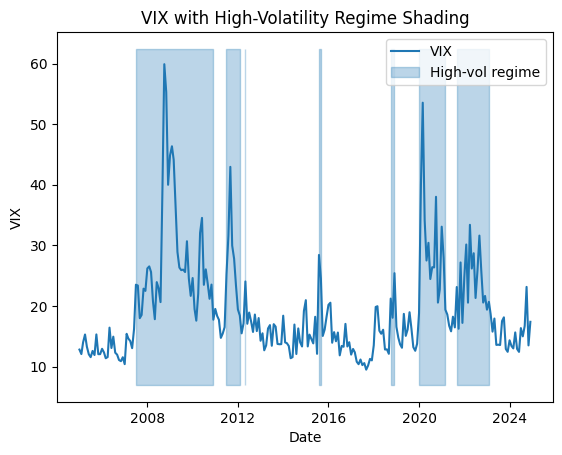

In [168]:
# Extract VIX series from macro data
vix = macro['vix']

# Fit a 2-state Markov switching model on VIX time series
ms_model = MarkovRegression(vix, k_regimes=2, trend='c', switching_variance=True)
ms_res = ms_model.fit(disp=False)

# Extract smoothed probability of high-volatility regime
#    (Assume regime 1 corresponds to high volatility)
s = ms_res.smoothed_marginal_probabilities.iloc[:, 1]


# Plot VIX and overlay shading for high-volatility periods
fig, ax = plt.subplots()
x = vix.index

# Plot the VIX time series
line, = ax.plot(x, vix.values, label='VIX')

# Get vertical axis bounds for shading
ymin, ymax = ax.get_ylim()

# Shade regions where high-volatility regime probability > 0.35
ax.fill_between(
    x,
    ymin,
    ymax,
    where=(s > 0.35),
    color=line.get_color(),
    alpha=0.3,
    label='High-vol regime'
)

# Set axis labels and plot title
ax.set_xlabel('Date')
ax.set_ylabel('VIX')
ax.set_title('VIX with High-Volatility Regime Shading')

# Show legend
ax.legend(loc='upper right')

# Display plot
plt.show()

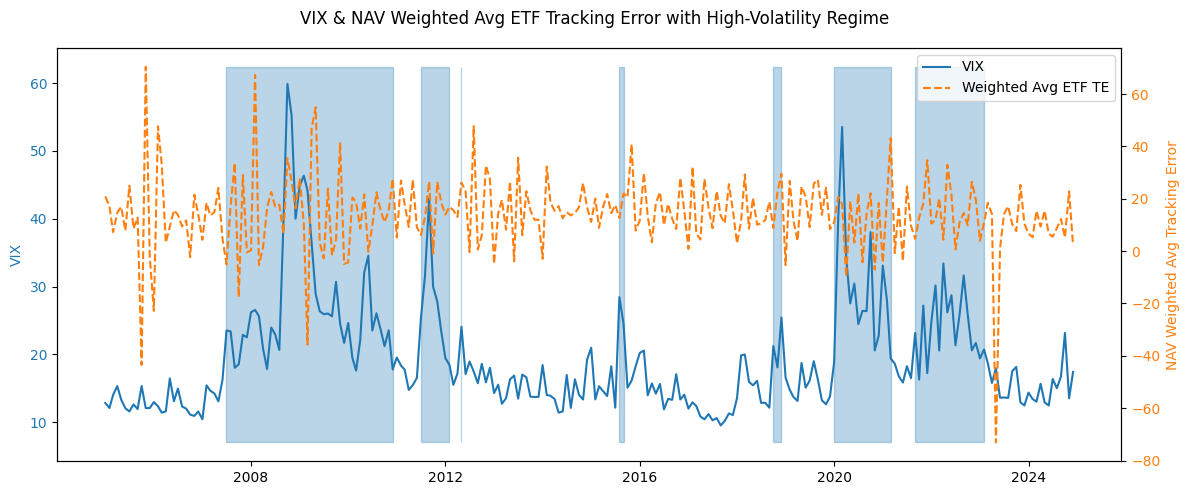

In [169]:
# Create a copy of the ETF data for weighted tracking error calculation
weighted_te = etf_data.copy()

# Drop rows with missing Tracking Error or Net Asset values
df_clean = weighted_te.dropna(subset=["Tracking_Error", "Net_Assets_USD"])

# Compute the NAV-weighted average tracking error for each date
weighted_te = (
    df_clean.groupby("Date")
            .apply(lambda g: np.average(g["Tracking_Error"], weights=g["Net_Assets_USD"]))
)

# Align weighted TE and VIX to a common time index
vix = macro['vix']
common_index = vix.index.intersection(weighted_te.index)
vix_aligned = vix.loc[common_index]
weighted_te_aligned = weighted_te.loc[common_index]

# Fit 2-regime Markov Switching model on VIX
ms_model = MarkovRegression(vix_aligned, k_regimes=2, trend='c', switching_variance=True)
ms_res = ms_model.fit(disp=False)

# Extract smoothed probability of being in high-volatility regime (assumed to be Regime 1)
s = ms_res.smoothed_marginal_probabilities.iloc[:, 1]

# Plot: VIX and NAV-weighted average tracking error with regime shading
fig, ax1 = plt.subplots(figsize=(12, 5))

# VIX on primary y-axis
line1, = ax1.plot(vix_aligned.index, vix_aligned.values, label="VIX", color="C0")
ax1.set_ylabel("VIX", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

# Highlight high-volatility periods (probability > 0.35)
ymin, ymax = ax1.get_ylim()
ax1.fill_between(vix_aligned.index, ymin, ymax, where=(s > 0.35),
                 color="C0", alpha=0.3, label="High-vol regime")

# Weighted average TE on secondary y-axis
ax2 = ax1.twinx()
line2, = ax2.plot(weighted_te_aligned.index, weighted_te_aligned.values,
                  label="Weighted Avg ETF TE", linestyle="--", color="C1")
ax2.set_ylabel("NAV Weighted Avg Tracking Error", color="C1")
ax2.tick_params(axis='y', labelcolor="C1")

# Title and combined legend
fig.suptitle("VIX & NAV Weighted Avg ETF Tracking Error with High-Volatility Regime")
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

plt.tight_layout()
plt.show()

### VIX Series Standardisation

In [170]:
# Variance-stabilizing transformation using sqrt-log
vix_pre = np.sqrt(np.log1p(vix))

# Z-score standardisation
vix_std = (vix_pre - vix_pre.mean()) / vix_pre.std()

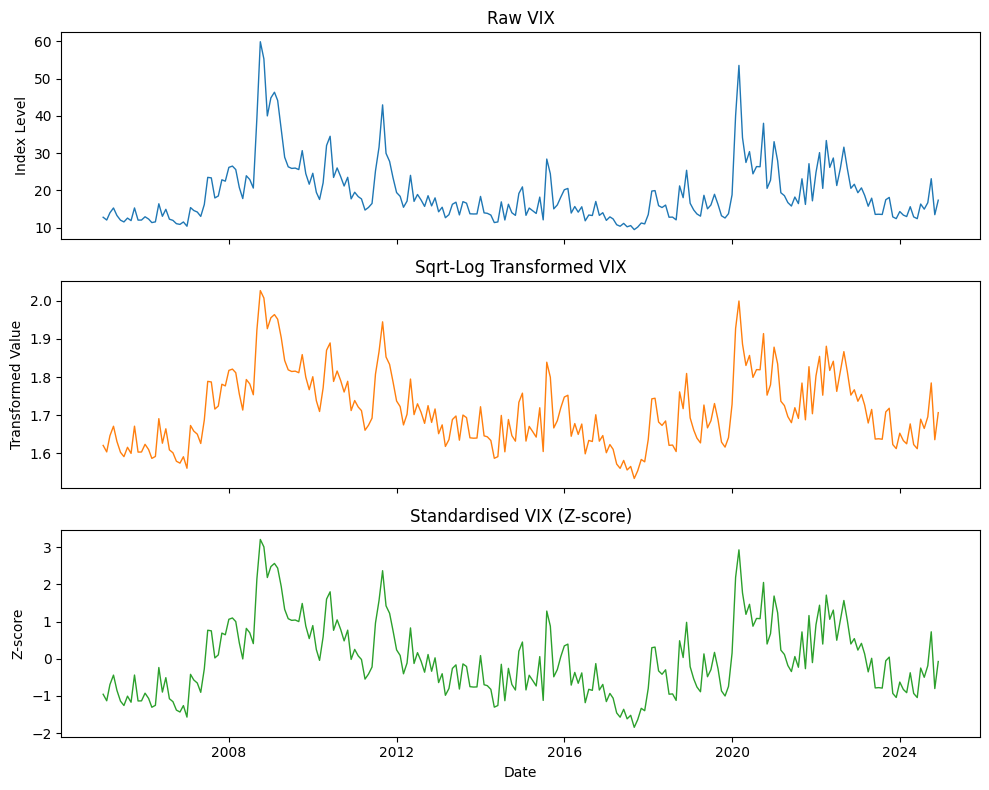

In [171]:
# Plot each series in its own vertical subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Plot 1 – Raw VIX
axes[0].plot(vix.index, vix, color='C0', lw=1)
axes[0].set_title("Raw VIX")
axes[0].set_ylabel("Index Level")

# Plot 2 – Variance-stabilized (sqrt-log)
axes[1].plot(vix_pre.index, vix_pre, color='C1', lw=1)
axes[1].set_title("Sqrt‑Log Transformed VIX")
axes[1].set_ylabel("Transformed Value")

# Plot 3 – Z-score standardised VIX
axes[2].plot(vix_std.index, vix_std, color='C2', lw=1)
axes[2].set_title("Standardised VIX (Z-score)")
axes[2].set_ylabel("Z-score")
axes[2].set_xlabel("Date")

# Adjust layout
plt.tight_layout()
plt.show()

### MS SARIMA (VIX Switch) Base Model

In [172]:
def fit_ms_sarima_vix(
    series: pd.Series,
    vix: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    regime_thresh: float = 0.5,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    forecast_plot: bool = True,
    alpha: float = 0.05,
) -> dict:
    """
    Fits a Markov-switching SARIMA model conditioned on a VIX regime signal.
    Performs expanding-window cross-validation and forecasts using regime-weighted mixtures
    of separate SARIMA models. Optionally returns residual diagnostics and a forecast plot.

    Parameters
    ----------
    series : pd.Series
        Time series of tracking errors to model.
    vix : pd.Series
        VIX time series to estimate regime probabilities.
    horizon : int
        Number of steps ahead to forecast.
    cv_window : int
        Initial window size for expanding-window cross-validation.
    cv_step : int
        Step size between CV folds.
    winsor_limits : tuple
        Winsorization limits for Yeo-Johnson transform.
    seasonal_period : int
        Seasonality (e.g., 12 for monthly data).
    regime_thresh : float
        Probability threshold to classify high-vol regime.
    n_jobs : int
        Number of parallel jobs for CV.
    arima_jobs : int
        Number of parallel jobs inside auto_arima.
    max_pq : int
        Max AR/MA and SAR/SMA orders.
    max_dD : int
        Max differencing orders (d and D).
    forecast_plot : bool
        If True, plots final CV forecast with GARCH CI and regime shading.
    alpha : float
        Significance level for residual diagnostics.

    Returns
    -------
    dict
        Dictionary with:
        - 'cv_metrics': CV performance metrics (MAE, MSE, R2).
        - 'residual_tests': Ljung-Box, Jarque-Bera, ARCH LM tests on residuals.
        - 'forecast_df': All CV forecasts (Date, Forecast, Actual, horizon).
    """
    
    # ─────────────────────────────────────────────────────────────
    # 0. Data Preparation and CV Fold Setup
    # ─────────────────────────────────────────────────────────────
    y = series.dropna()
    v = vix.reindex_like(y).ffill()
    if len(y) < cv_window + horizon:
        raise ValueError("Series too short for chosen cv_window + horizon.")

    fold_ends = list(range(cv_window, len(y) - horizon + 1, cv_step))
    if fold_ends[-1] != len(y) - horizon:
        fold_ends.append(len(y) - horizon)

    # ─────────────────────────────────────────────────────────────
    # 1. Regime Estimation on Full VIX Series
    # ─────────────────────────────────────────────────────────────
    def _regimes(v_sub):
        res = MarkovRegression(v_sub, k_regimes=2, trend="c",
                               switching_variance=True, switching_trend=True).fit(disp=False)
        p00, p10 = res.params["p[0->0]"], res.params["p[1->0]"]
        return res.smoothed_marginal_probabilities.iloc[:, 1], \
               np.array([[p00, 1 - p00], [p10, 1 - p10]])

    prob_full, P_full = _regimes(v)

    # ─────────────────────────────────────────────────────────────
    # 2. SARIMA Model Fitting Helper
    # ─────────────────────────────────────────────────────────────
    def _sarima_fit(ts):
        ts_t, tf_par = winsorize_yj(ts, winsor_limits)
        try:
            mod = auto_arima(ts_t, seasonal=True, m=seasonal_period, ic="aic",
                             max_p=max_pq, max_q=max_pq, max_d=max_dD,
                             max_P=max_pq, max_Q=max_pq, max_D=max_dD,
                             stepwise=True, maxiter=20, suppress_warnings=True,
                             error_action="ignore", n_jobs=arima_jobs)
        except ValueError:
            mod = auto_arima(ts_t, seasonal=False, ic="aic",
                             max_p=max_pq, max_q=max_pq, max_d=max_dD,
                             stepwise=True, maxiter=20, suppress_warnings=True,
                             error_action="ignore", n_jobs=arima_jobs)
        fc = inv_yj(mod.predict(horizon), tf_par)
        return mod, tf_par, fc

    # ─────────────────────────────────────────────────────────────
    # 3. Cross-Validation Fold Worker
    # ─────────────────────────────────────────────────────────────
    def _cv_fold(end):
        y_tr, y_te = y.iloc[:end], y.iloc[end:end+horizon]
        prob = prob_full.iloc[:end]
        P = P_full
        flag = prob > regime_thresh

        if flag.all() or (~flag).all():
            lo_mod, lo_tf, lo_fc = _sarima_fit(y_tr)
            hi_mod, hi_tf, hi_fc = lo_mod, lo_tf, lo_fc
        else:
            lo_mod, lo_tf, lo_fc = _sarima_fit(y_tr.loc[~flag])
            hi_mod, hi_tf, hi_fc = _sarima_fit(y_tr.loc[ flag])

        p_vec = np.array([1 - prob.iloc[-1], prob.iloc[-1]])
        fc_mix = []
        for h in range(horizon):
            p_vec = p_vec @ P
            fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])

        fc_df = pd.DataFrame({
            "Date":     y_te.index,
            "Forecast": fc_mix,
            "Actual":   y_te.values,
            "horizon":  horizon
        })

        return (
            mean_absolute_error(y_te, fc_mix),
            mean_squared_error(y_te, fc_mix),
            r2_score(y_te, fc_mix),
            fc_df
        )

    # ─────────────────────────────────────────────────────────────
    # 4. Run Cross-Validation Folds
    # ─────────────────────────────────────────────────────────────
    res_list = Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends)
    mae, mse, r2, fc_dfs = zip(*res_list)

    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": list(mae), "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": list(mse), "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": list(r2),  "mean": np.mean(r2),  "std": np.std(r2)},
    }

    forecast_df = pd.concat(fc_dfs, ignore_index=True)

    # ─────────────────────────────────────────────────────────────
    # 5. Residual Diagnostics on Final Fit
    # ─────────────────────────────────────────────────────────────
    tr_y, te_y = y.iloc[:-horizon], y.iloc[-horizon:]
    prob_f = prob_full.iloc[:-horizon]
    P_f = P_full
    flag_f = prob_f > regime_thresh

    if flag_f.all() or (~flag_f).all():
        lo_mod, lo_tf, lo_fc = _sarima_fit(tr_y)
        hi_mod, hi_tf, hi_fc = lo_mod, lo_tf, lo_fc
    else:
        lo_mod, lo_tf, lo_fc = _sarima_fit(tr_y.loc[~flag_f])
        hi_mod, hi_tf, hi_fc = _sarima_fit(tr_y.loc[ flag_f])

    lo_fit = inv_yj(lo_mod.predict_in_sample(), lo_tf)
    hi_fit = inv_yj(hi_mod.predict_in_sample(), hi_tf)
    fitted = pd.Series(index=tr_y.index, dtype=float)
    fitted.loc[~flag_f] = lo_fit
    fitted.loc[ flag_f] = hi_fit
    resid = tr_y - fitted

    lb_stat, lb_p = acorr_ljungbox(resid, lags=[10], return_df=True).iloc[0]
    jb_stat, jb_p = jarque_bera(resid)[:2]
    arch_stat, arch_p, *_ = het_arch(resid, nlags=10)

    residual_tests = {
        "Serial_LB(Q10)": {"stat": lb_stat, "p": lb_p,
                           "Result": "Fail" if lb_p < alpha else "Pass"},
        "Normality_JB":   {"stat": jb_stat, "p": jb_p,
                           "Result": "Fail" if jb_p < alpha else "Pass"},
        "ARCH_LM(10)":    {"stat": arch_stat, "p": arch_p,
                           "Result": "Fail" if arch_p < alpha else "Pass"},
    }

    print("\n=== Residual Diagnostics ===")
    for k, d in residual_tests.items():
        print(f"{k:15s} stat={d['stat']:.3f}  p={d['p']:.4f}  → {d['Result']}")

    # ─────────────────────────────────────────────────────────────
    # 6. Optional Final Fold Forecast Plot
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        def _sigma(mod, sub_series):
            resid = pd.Series(mod.arima_res_.resid,
                              index=sub_series.index[-len(mod.arima_res_.resid):])
            z = resid / resid.std()
            gfit = arch_model(z, vol="Garch", p=1, q=1, dist="t", rescale=False).fit(disp="off")
            var_h = gfit.forecast(horizon=horizon, reindex=False).variance.iloc[-1]
            return np.sqrt(var_h) * resid.std()

        sig_lo = _sigma(lo_mod, tr_y.loc[~flag_f] if (~flag_f).any() else tr_y)
        sig_hi = _sigma(hi_mod, tr_y.loc[ flag_f] if  flag_f.any()  else tr_y)

        p_vec = np.array([1 - prob_f.iloc[-1], prob_f.iloc[-1]])
        fc_mix, sigma_mix = [], []
        for h in range(horizon):
            p_vec = p_vec @ P_f
            fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])
            sigma_mix.append(np.sqrt(p_vec[0] * sig_lo[h]**2 + p_vec[1] * sig_hi[h]**2))

        prev_n = 10
        idx_prev = y.index[-(prev_n + horizon):-horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, te_y.index], np.r_[y.loc[idx_prev], te_y.values],
                 "-o", color="C0", label="Actual", zorder=2)
        plt.plot(np.r_[idx_prev, te_y.index], np.r_[y.loc[idx_prev].values, fc_mix],
                 "--o", color="C1", label="Forecast", zorder=1)
        plt.errorbar(te_y.index, fc_mix, yerr=1.96 * np.array(sigma_mix),
                     fmt="none", ecolor="grey", alpha=0.5, capsize=5,
                     label="GARCH 95% CI")

        shade = pd.concat([
            prob_f.iloc[-prev_n:],
            pd.Series([p_vec[1]] * horizon, index=te_y.index)
        ])
        ymin, ymax = plt.ylim()
        plt.fill_between(shade.index, ymin, ymax, where=shade > regime_thresh,
                         color="C2", alpha=0.3, label="High-Vol Regime")

        plt.title(f"Final CV Fold: MS-SARIMA ({horizon}-step)")
        plt.xlabel("Date")
        plt.ylabel(series.name or "Value")
        plt.legend()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 7. Return Results
    # ─────────────────────────────────────────────────────────────
    return {
        "cv_metrics": cv_metrics,
        "residual_tests": residual_tests,
        "forecast_df": forecast_df
    }

### MS SARIMA (VIX Switch) Panel Fit

In [173]:
def run_ms_vix_panel(
    panel_df: pd.DataFrame,
    vix_series: pd.Series,
    target_col="Tracking_Error",
    ticker_col="ETF_Ticker",
    date_col="Date",
    horizon=3, cv_window=60, cv_step=30,
    winsor_limits=(0.01, 0.01), seasonal_period=12,
    regime_thresh=0.5,
    n_jobs=-1, arima_jobs=1, max_pq=3, max_dD=3,
    alpha=0.05, plot_ticker=None
):
    """
    Fit MS-SARIMA(VIX) model across all ETFs in panel using parallel cross-validation.

    Parameters
    ----------
    panel_df : pd.DataFrame
        Panel of ETF tracking error data with columns for tickers and dates.
    vix_series : pd.Series
        VIX time series to drive Markov-switching regimes.
    target_col : str
        Column name for the target variable (default "Tracking_Error").
    ticker_col : str
        Column name for ETF identifier (default "ETF_Ticker").
    date_col : str
        Column name for date (default "Date").
    horizon : int
        Forecast horizon (steps ahead).
    cv_window : int
        Initial window size for expanding-window cross-validation.
    cv_step : int
        Step size between folds.
    winsor_limits : tuple
        Limits for winsorization before transformation.
    seasonal_period : int
        Seasonal period for SARIMA (e.g. 12 for monthly).
    regime_thresh : float
        Threshold for regime classification from VIX probabilities.
    n_jobs : int
        Number of parallel jobs for panel-level processing.
    arima_jobs : int
        Number of jobs for `auto_arima` fitting.
    max_pq : int
        Max AR and MA orders for SARIMA.
    max_dD : int
        Max differencing and seasonal differencing orders.
    alpha : float
        Significance level for residual diagnostics.
    plot_ticker : str or None
        ETF ticker to plot forecast for (final fold only).

    Returns
    -------
    Tuple of:
        - ms_vix_cv_fold_df        : Per-fold CV metrics averaged across ETFs
        - ms_vix_cv_summary_df     : Global summary (mean/std of each metric)
        - ms_vix_per_etf_df        : Per-ETF mean/std metrics
        - ms_vix_resid_diag_df     : Residual test stats and pass/fail counts
        - ms_vix_forecast_df       : All fold-level forecasts across ETFs
    """
    
    def _run_one(etf):
        ser = (panel_df.loc[panel_df[ticker_col] == etf]
                          .sort_values(date_col)[target_col])
        res = fit_ms_sarima_vix(
            ser, vix_series,
            horizon, cv_window, cv_step, winsor_limits,
            seasonal_period, regime_thresh,
            n_jobs=1, arima_jobs=arima_jobs,
            max_pq=max_pq, max_dD=max_dD,
            forecast_plot=(etf == plot_ticker), alpha=alpha
        )
        fc = res["forecast_df"].copy()
        fc["ETF"] = etf
        return etf, res["cv_metrics"], res["residual_tests"], fc

    results = Parallel(n_jobs=n_jobs)(
        delayed(_run_one)(etf) for etf in panel_df[ticker_col].unique()
    )

    # Per-ETF summary metrics
    per_rows = []
    resid_rows = {"Serial_LB(Q10)": [], "Normality_JB": [], "ARCH_LM(10)": []}

    for etf, cv, diag, _ in results:
        per_rows.append([
            etf,
            cv["MAE"]["mean"], cv["MAE"]["std"],
            cv["MSE"]["mean"], cv["MSE"]["std"],
            cv["R2"]["mean"]
        ])
        for k in resid_rows:
            resid_rows[k].append(diag[k])

    ms_vix_per_etf_df = pd.DataFrame(
        per_rows,
        columns=["ETF", "MAE", "MAE_std", "MSE", "MSE_std", "R2"]
    ).set_index("ETF").sort_index()

    # Residual diagnostics across ETFs
    diag_rows = []
    for k, lst in resid_rows.items():
        stat_mean = np.mean([d["stat"] for d in lst])
        p_mean = np.mean([d["p"] for d in lst])
        fails = sum(d["Result"] == "Fail" for d in lst)
        passes = len(lst) - fails
        diag_rows.append([k, stat_mean, p_mean, fails, passes])

    ms_vix_resid_diag_df = pd.DataFrame(
        diag_rows,
        columns=["Test", "stat_mean", "p_mean", "Fail_count", "Pass_count"]
    ).set_index("Test")

    # Per-fold averages across ETFs
    n_folds = results[0][1]["folds"]
    fold_rows = []
    for f in range(n_folds):
        mae_vals = [cv["MAE"]["values"][f] for _, cv, _, _ in results]
        mse_vals = [cv["MSE"]["values"][f] for _, cv, _, _ in results]
        r2_vals = [cv["R2"]["values"][f] for _, cv, _, _ in results]
        fold_rows.append([
            f + 1,
            np.mean(mae_vals), np.std(mae_vals),
            np.mean(mse_vals), np.std(mse_vals),
            np.mean(r2_vals)
        ])

    ms_vix_cv_fold_df = pd.DataFrame(
        fold_rows,
        columns=["Fold", "MAE", "MAE_std", "MSE", "MSE_std", "R2"]
    )

    # Global summary table
    ms_vix_cv_summary_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "R2"],
        "Mean": [
            ms_vix_cv_fold_df["MAE"].mean(),
            ms_vix_cv_fold_df["MSE"].mean(),
            ms_vix_cv_fold_df["R2"].mean()
        ],
        "Std": [
            ms_vix_cv_fold_df["MAE"].std(),
            ms_vix_cv_fold_df["MSE"].std(),
            ms_vix_cv_fold_df["R2"].std()
        ]
    }).set_index("Metric")

    # Combine all forecast DataFrames
    ms_vix_forecast_df = pd.concat([fc for *_, fc in results],
                                   ignore_index=True)

    return (
        ms_vix_cv_fold_df,
        ms_vix_cv_summary_df,
        ms_vix_per_etf_df,
        ms_vix_resid_diag_df,
        ms_vix_forecast_df
    )

### MS SARIMA (VIX Switch) Panel Results

In [174]:
# Run the Markov-Switching SARIMA–GARCH Model on VIX
(ms_vix_cv_fold_df,
 ms_vix_cv_summary_df,
 ms_vix_per_etf_df,
 ms_vix_resid_diag_df,
 ms_vix_forecast_df) = run_ms_vix_panel(
    etf_data, 
    vix_series=vix_std,
    horizon=3, 
    cv_window=cv_window, 
    cv_step=cv_step,
    n_jobs=-1, 
    regime_thresh=0.5 
)


In [175]:
# Display the results
print("\n=== MS-VIX: CV fold means across ETFs ===")
display(ms_vix_cv_fold_df.style.format("{:.6f}"))

print("\n=== MS-VIX: overall mean ± std ===")
display(ms_vix_cv_summary_df.style.format("{:.6f}"))

print("\n=== MS-VIX: per-ETF metrics ===")
display(ms_vix_per_etf_df.style.format("{:.6f}"))

print("\n=== MS-VIX: aggregate residual diagnostics ===")
display(ms_vix_resid_diag_df.style.format("{:.4f}"))


=== MS-VIX: CV fold means across ETFs ===


,Fold,MAE,MAE_std,MSE,MSE_std,R2
0,1.000000,34.449150,70.617084,13527.471577,60517.665899,-0.693201
1,2.000000,28.100101,20.909511,1502.816097,1937.423359,-0.171930
2,3.000000,16.667636,24.065770,1066.195732,2862.646758,-2.636042
3,4.000000,13.248254,18.927138,619.407838,2073.306818,-1.107843
4,5.000000,29.841473,75.750854,8760.450959,44671.994871,-0.866221
5,6.000000,20.743643,41.441234,2953.356273,9555.045932,-1.387222
6,7.000000,31.269678,47.770237,3943.796844,10442.053838,-0.476978



=== MS-VIX: overall mean ± std ===


,Mean,Std
Metric,,
MAE,24.902848,8.033556
MSE,4624.785046,4797.087201
R2,-1.048491,0.805504



=== MS-VIX: per-ETF metrics ===


,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,11.605596,5.299446,209.506372,199.225799,0.047856
IDU,61.048786,27.619450,6836.551079,5791.244635,-0.666646
IJH,6.713202,4.349421,73.578881,93.088183,-0.647993
IJR,9.969351,6.337959,170.895531,184.578866,-0.489361
IVV,9.957227,7.744799,186.895260,244.849811,-0.556832
IWB,8.821323,3.365295,103.007214,85.372735,-0.614639
IWD,12.592707,6.089103,272.610481,279.690861,-1.982771
IWF,13.339583,13.841193,460.397443,866.414791,-0.731940
IWM,10.370494,8.259117,251.011787,406.173758,-0.194846



=== MS-VIX: aggregate residual diagnostics ===


,stat_mean,p_mean,Fail_count,Pass_count
Test,,,,
Serial_LB(Q10),24.3290,0.1519,19.0000,11.0000
Normality_JB,1724.2705,0.0000,30.0000,0.0000
ARCH_LM(10),44.0911,0.1150,24.0000,6.0000


All three residual diagnostics fail (p < 0.05), indicating the MS-VIX-SARIMA + GARCH model has not purged all predictable structure.

Ljung-Box Q(10) detects short-run autocorrelation; Jarque-Bera flags heavy-tailed, non-Gaussian errors; ARCH-LM(10) reveals remaining volatility clustering.

These results point to remaining non-linear and interaction effects—e.g., asymmetric responses to VIX spikes, ETF-specific frictions—that classical linear/regime models cannot express.

# Gradient Boosted Decision Tree Model Fitting

### Helper Functions

In [176]:
def make_features(df, target="Tracking_Error", lags=(1, 2, 3)):
    """
    Generate lagged numeric features and integer-coded categorical variables from ETF dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing time series and static features for multiple ETFs.
    target : str
        Name of the target column to predict (default is "Tracking_Error").
    lags : tuple of int
        Lag values to create for all numeric columns.

    Returns
    -------
    X : pd.DataFrame
        Feature matrix including lagged variables and integer-encoded categorical variables.
    y : pd.Series
        Target variable aligned with X.
    df : pd.DataFrame
        Cleaned and augmented full DataFrame (with ETF_Ticker, Date, etc.).
    """
    df = df.copy()

    # Ensure presence of a "Date" column
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "Date"})
        else:
            raise KeyError("Need a Date column or datetime index.")

    # Sort to ensure correct lagging
    df = df.sort_values(["ETF_Ticker", "Date"])

    # Add lagged versions of all numeric columns
    num_cols = df.select_dtypes(include="number").columns.tolist()
    for col in num_cols:
        for l in lags:
            df[f"{col}_lag{l}"] = df.groupby("ETF_Ticker")[col].shift(l)

    # Preserve string ticker, but add an integer code
    df["ETF_code"] = pd.Categorical(df["ETF_Ticker"]).codes.astype("int32")

    # Convert all other categorical columns to integer codes
    cat_cols = [c for c in df.columns if c not in num_cols + ["Date", "ETF_Ticker", "ETF_code"]]
    for col in cat_cols:
        df[col] = pd.Categorical(df[col]).codes.astype("int32")

    # Drop columns with only one unique value and rows with missing values
    nunq = df.nunique(dropna=True)
    df = df.drop(columns=nunq[nunq <= 1].index).dropna()

    # Split features and target
    X = df.drop(columns=[target, "Date", "ETF_Ticker"])  # Keep ETF_code
    y = df[target]
    return X, y, df

In [177]:
def report_cv(cv):
    """
    Display cross-validation fold results and print mean ± std for each metric.

    Parameters
    ----------
    cv : dict
        Dictionary containing keys: 'folds', and nested metrics (MAE, MSE, R2),
        each with 'values', 'mean', and 'std'.
    """
    print("\n=== Cross-Validation Results ===")
    
    # Display table of metrics for each fold
    cv_df = pd.DataFrame({
        "Fold": range(1, cv["folds"] + 1),
        "MAE":  cv["MAE"]["values"],
        "MSE":  cv["MSE"]["values"],
        "R2":   cv["R2"]["values"],
    })
    display(cv_df.style.format("{:.6f}"))

    # Print mean ± std for each metric
    for k in ["MAE", "MSE", "R2"]:
        print(f"{k} mean ± std : {cv[k]['mean']:.6f} ± {cv[k]['std']:.6f}")

### XGBoost Model Fit

In [178]:
def fit_xgboost(
    df: pd.DataFrame,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    xgb_params: dict | None = None,
    forecast_plot: bool = True,
    plot_ticker: str | None = None,
    top_n_importance: int = 20,
):
    """
    Fit an expanding-window XGBoost model to forecast ETF tracking error.

    Parameters
    ----------
    df : pd.DataFrame
        Long-format DataFrame with Date, ETF_Ticker, Tracking_Error, and predictors.
    horizon : int, default=3
        Forecast horizon in time steps.
    cv_window : int, default=60
        Minimum number of observations to start cross-validation.
    cv_step : int, default=30
        Step size for each expanding fold.
    xgb_params : dict or None, default=None
        Optional dictionary of XGBoost hyperparameters to override defaults.
    forecast_plot : bool, default=True
        If True, plots forecast vs actual for final fold.
    plot_ticker : str or None, default=None
        ETF ticker to use for final forecast plot (random if None).
    top_n_importance : int, default=20
        Number of top features to display in importance and SHAP plots.

    Returns
    -------
    dict
        Dictionary with CV metrics, per-ETF errors, feature importance,
        SHAP values, learning curve, and per-fold forecasts.
    """
    
    # ─────────────────────────────────────────────────────────────
    # 1. Preprocessing: feature engineering and indexing
    # ─────────────────────────────────────────────────────────────
    X_full, y_full, full = make_features(df)
    dates = np.sort(full["Date"].unique())

    # ─────────────────────────────────────────────────────────────
    # 2. Expanding-Window CV Fold Ends
    # ─────────────────────────────────────────────────────────────
    fold_ends = list(range(cv_window, len(dates) - horizon + 1, cv_step))
    if fold_ends[-1] != len(dates) - horizon:
        fold_ends.append(len(dates) - horizon)

    # ─────────────────────────────────────────────────────────────
    # 3. Hyperparameter Setup
    # ─────────────────────────────────────────────────────────────
    params = dict(
        objective="reg:squarederror", n_estimators=600, learning_rate=0.05,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        tree_method="hist", enable_categorical=True, n_jobs=-1,
        random_state=0, eval_metric=["rmse"]
    )
    if xgb_params:
        params.update(xgb_params)

    mae_vals, mse_vals, r2_vals, fc_rows = [], [], [], []

    # ─────────────────────────────────────────────────────────────
    # 4. Expanding-Window CV Loop
    # ─────────────────────────────────────────────────────────────
    for pos in tqdm(fold_ends, desc="CV folds", unit="fold"):
        train_dates = dates[:pos+1]
        valid_dates = dates[pos+1:pos+1+horizon]

        tr_mask = full["Date"].isin(train_dates)
        va_mask = full["Date"].isin(valid_dates)

        model = XGBRegressor(**params).fit(
            X_full.loc[tr_mask], y_full.loc[tr_mask]
        )
        preds = model.predict(X_full.loc[va_mask])

        mae_vals.append(mean_absolute_error(y_full.loc[va_mask], preds))
        mse_vals.append(mean_squared_error(y_full.loc[va_mask], preds))
        r2_vals .append(r2_score        (y_full.loc[va_mask], preds))

        fc_rows.append(pd.DataFrame({
            "Date"      : full.loc[va_mask, "Date"].values,
            "ETF"       : full.loc[va_mask, "ETF_Ticker"].values,
            "horizon"   : horizon,
            "Forecast"  : preds,
            "Actual"    : y_full.loc[va_mask].values
        }))

    # ─────────────────────────────────────────────────────────────
    # 4b. Combine Per-Fold Forecasts
    # ─────────────────────────────────────────────────────────────
    forecast_df = pd.concat(fc_rows, ignore_index=True)

    # ─────────────────────────────────────────────────────────────
    # 5. Final Model Fit (on last window)
    # ─────────────────────────────────────────────────────────────
    pos = fold_ends[-1]
    train_dates = dates[:pos+1]
    valid_dates = dates[pos+1:pos+1+horizon]

    tr_mask = full["Date"].isin(train_dates)
    va_mask = full["Date"].isin(valid_dates)

    final_model = XGBRegressor(**params).fit(
        X_full.loc[tr_mask], y_full.loc[tr_mask],
        eval_set=[(X_full.loc[tr_mask], y_full.loc[tr_mask]),
                  (X_full.loc[va_mask], y_full.loc[va_mask])],
        verbose=False
    )
    preds_final = final_model.predict(X_full.loc[va_mask])

    # ─────────────────────────────────────────────────────────────
    # 6. Global Feature Importance (Gain)
    # ─────────────────────────────────────────────────────────────
    imp_series = pd.Series(
        final_model.get_booster().get_score(importance_type="gain"),
        name="gain"
    ).sort_values(ascending=False)

    top_imp = imp_series.head(top_n_importance)
    plt.figure(figsize=(10, 0.35*len(top_imp)+1))
    top_imp[::-1].plot(kind="barh", color="C1")
    plt.title(f"Top {len(top_imp)} Features by Gain")
    plt.xlabel("Gain"); plt.tight_layout(); plt.show()

    # ─────────────────────────────────────────────────────────────
    # 7. SHAP Summary Plot
    # ─────────────────────────────────────────────────────────────
    sample_idx = np.random.choice(X_full.shape[0], size=min(5000, X_full.shape[0]), replace=False)
    shap_sample_X = X_full.iloc[sample_idx]
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(shap_sample_X)

    shap.summary_plot(
        shap_values, shap_sample_X,
        show=False, max_display=top_n_importance,
        plot_size=(10, 6)
    )
    plt.title("SHAP Value Summary Plot (Top Features)")
    plt.tight_layout(); plt.show()

    # ─────────────────────────────────────────────────────────────
    # 8. Final Fold: Per-ETF MAE, MSE, R² ± std
    # ─────────────────────────────────────────────────────────────
    rows = []
    valid_full = full.loc[va_mask].copy()
    valid_full["pred"] = preds_final

    for etf, g in valid_full.groupby("ETF_Ticker"):
        err = g["Tracking_Error"] - g["pred"]
        rows.append([
            etf,
            err.abs().mean(),  err.abs().std(ddof=0),
            (err**2).mean(),   (err**2).std(ddof=0),
            r2_score(g["Tracking_Error"], g["pred"]),
        ])

    per_df = pd.DataFrame(rows, columns=[
        "ETF", "MAE", "MAE_std", "MSE", "MSE_std", "R2"
    ]).set_index("ETF").sort_index()

    display(per_df.style.format("{:.6f}"))

    # ─────────────────────────────────────────────────────────────
    # 9. Extract Learning Curve from Final Fit
    # ─────────────────────────────────────────────────────────────
    ev = final_model.evals_result_
    learning_curve = {
        "train_rmse": ev["validation_0"]["rmse"],
        "valid_rmse": ev["validation_1"]["rmse"],
    }

    # ─────────────────────────────────────────────────────────────
    # 10. Optional Final Fold Forecast Plot
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        ticker = plot_ticker or per_df.index[0]
        mask_ticker = full["ETF_Ticker"] == ticker

        act = full.loc[va_mask & mask_ticker, ["Date", "Tracking_Error"]].copy()
        act["Forecast"] = preds_final[mask_ticker[va_mask].values]

        hist = full.loc[tr_mask & mask_ticker, ["Date", "Tracking_Error"]].tail(10)

        plt.figure(figsize=(10, 4))
        plt.plot(pd.concat([hist["Date"], act["Date"]]),
                 pd.concat([hist["Tracking_Error"], act["Forecast"]]),
                 "--o", label="Forecast", color="C1", zorder=1)
        plt.plot(pd.concat([hist["Date"], act["Date"]]),
                 pd.concat([hist["Tracking_Error"], act["Tracking_Error"]]),
                 "-o", label="Actual", color="C0", zorder=2)
        plt.title(f"Final CV Fold: XGBoost Forecast ({horizon}-step)")
        plt.xlabel("Date"); plt.ylabel("Tracking Error"); plt.legend()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 11. Return All Results in a Dictionary
    # ─────────────────────────────────────────────────────────────
    return {
        "cv_metrics": {
            "folds": len(mae_vals),
            "MAE": {"values": mae_vals, "mean": np.mean(mae_vals), "std": np.std(mae_vals)},
            "MSE": {"values": mse_vals, "mean": np.mean(mse_vals), "std": np.std(mse_vals)},
            "R2":  {"values": r2_vals,  "mean": np.mean(r2_vals),  "std": np.std(r2_vals)},
        },
        "cv_fold_df": pd.DataFrame({
            "Fold": range(1, len(mae_vals)+1),
            "MAE":  mae_vals,
            "MSE":  mse_vals,
            "R2":   r2_vals
        }).set_index("Fold"),
        "feature_importance_df": imp_series,
        "per_etf_metrics": per_df,
        "learning_curve": learning_curve,
        "shap_values": shap_values,
        "shap_sample_X": shap_sample_X,
        "forecast_df": forecast_df            
    }

### XGBoost Results

CV folds: 100%|██████████| 7/7 [00:15<00:00,  2.28s/fold]


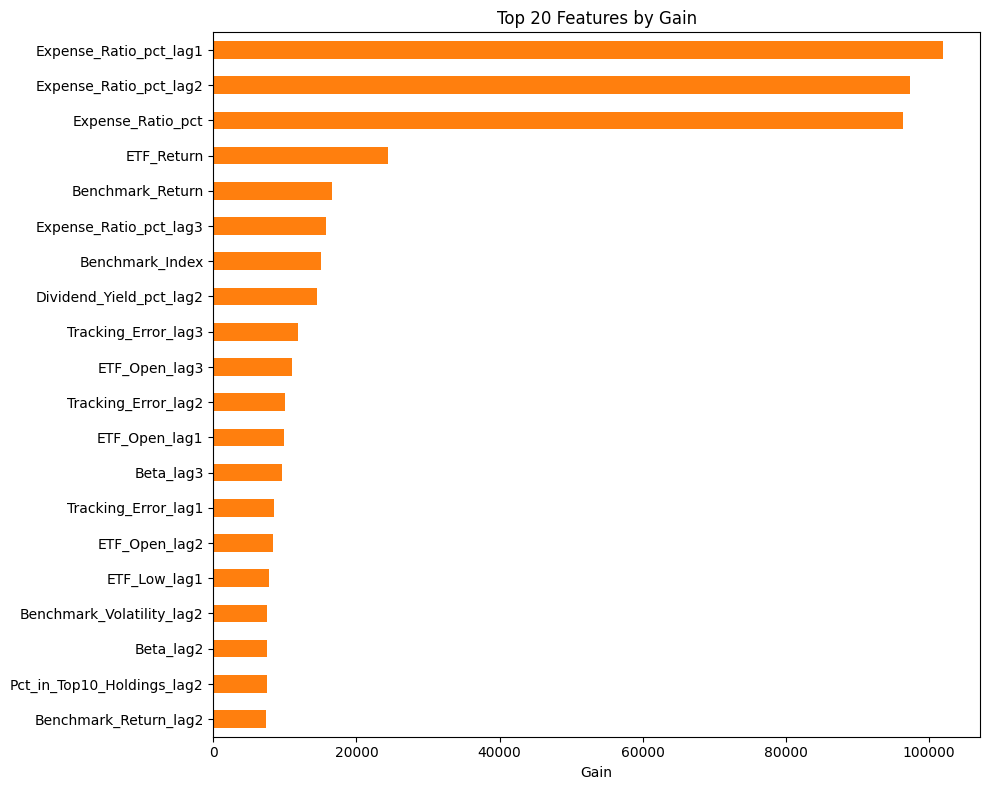

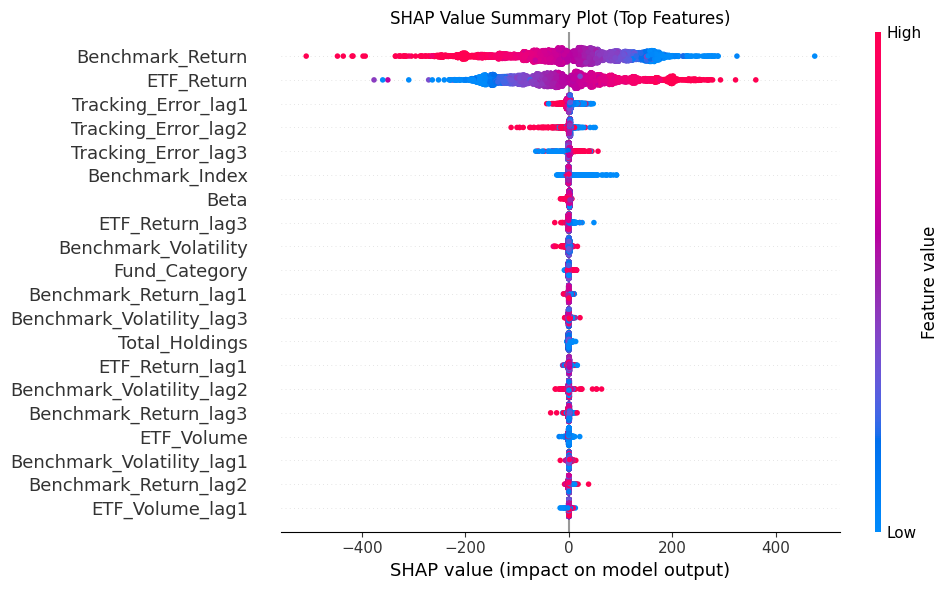

,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,4.226044,3.028011,27.028295,25.593012,0.773548
IDU,26.735049,8.915706,794.252678,476.723676,-0.680504
IJH,9.332025,3.139205,96.941292,58.590272,0.133142
IJR,10.164324,4.739984,125.780924,96.357467,0.590925
IVV,1.025124,0.567087,1.372467,1.162669,0.943186
IWB,1.692960,0.747625,3.425057,2.531399,0.944419
IWD,4.438748,1.122129,20.961652,9.961691,0.767493
IWF,0.808760,0.091152,0.662402,0.147441,0.930849
IWM,4.873292,2.434576,29.676140,23.728803,0.762576


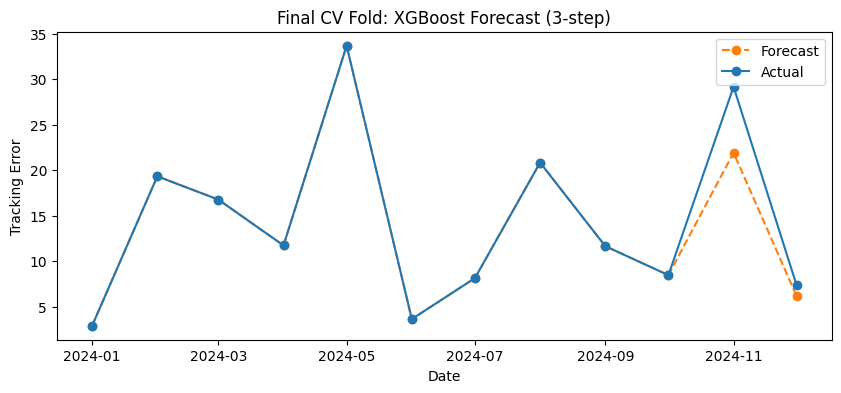

In [179]:
# Fit XGBoost model 
xgboost_results = fit_xgboost(
    etf_data,
    horizon=3,
    cv_window=cv_window,
    cv_step=cv_step
)


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,22.162662,2002.268485,0.623339
1,2.000000,14.709351,552.267565,0.747348
2,3.000000,12.010433,498.595958,0.499200
3,4.000000,8.310080,258.294217,0.686860
4,5.000000,36.314133,5698.487005,-0.009495
5,6.000000,21.042717,2961.964749,0.527323
6,7.000000,11.735967,411.451728,0.857602


MAE mean ± std : 18.040763 ± 8.797870
MSE mean ± std : 1769.047101 ± 1856.955293
R2 mean ± std : 0.561740 ± 0.259901

=== Learning Curve ===


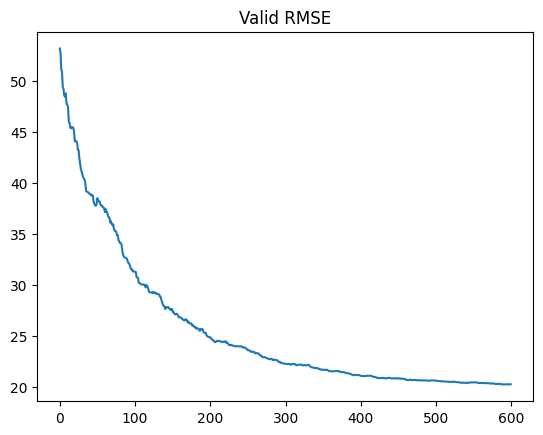

In [180]:
# Display cross-validation results
report_cv(xgboost_results["cv_metrics"])

# Display the learning curve
print("\n=== Learning Curve ===")
plt.plot(xgboost_results["learning_curve"]["valid_rmse"]); plt.title("Valid RMSE"); plt.show()

# Hybrid Model

### Hybrid Model Helper Functions

In [181]:
def _sarima_fit(ts, winsor_limits, m, max_pq, max_dD, arima_jobs):
    """
    Fit a SARIMA model to the transformed time series with seasonal fallback.

    Parameters
    ----------
    ts : pd.Series
        Raw time series to model.
    winsor_limits : tuple
        Lower and upper bounds for winsorization.
    m : int
        Seasonal period.
    max_pq : int
        Maximum AR and MA orders (p, q, P, Q).
    max_dD : int
        Maximum integration orders (d, D).
    arima_jobs : int
        Number of parallel jobs for auto_arima.

    Returns
    -------
    mod : pmdarima.ARIMA
        Fitted ARIMA model.
    tf_par : dict
        Transformation parameters (lambda, shift).
    """
    ts_t, tf_par = winsorize_yj(ts, winsor_limits)

    try:
        mod = auto_arima(ts_t, seasonal=True, m=m, ic="aic",
                         max_p=max_pq, max_q=max_pq, max_d=max_dD,
                         max_P=max_pq, max_Q=max_pq, max_D=max_dD,
                         stepwise=True, maxiter=50, suppress_warnings=True,
                         error_action="ignore", n_jobs=arima_jobs)
    except ValueError:
        mod = auto_arima(ts_t, seasonal=False, ic="aic",
                         max_p=max_pq, max_q=max_pq, max_d=max_dD,
                         stepwise=True, maxiter=50, suppress_warnings=True,
                         error_action="ignore", n_jobs=arima_jobs)

    return mod, tf_par

In [182]:
def _regimes(v_sub):
    """
    Fit a two-regime Markov Switching model to a volatility proxy (e.g. VIX).

    Parameters
    ----------
    v_sub : pd.Series
        Time series to model (typically a volatility index like VIX).

    Returns
    -------
    smoothed_prob : pd.Series
        Probability of being in the high-volatility regime at each time step.
    P : np.ndarray
        2×2 transition probability matrix between regimes.
    """
    # Fit two-regime Markov Switching model with constant mean and switching variance
    res = MarkovRegression(v_sub, k_regimes=2, trend="c",
                           switching_variance=True).fit(disp=False)

    # Extract transition probabilities
    p00 = res.params["p[0->0]"]  # Prob of staying in Regime 0
    p10 = res.params["p[1->0]"]  # Prob of switching from Regime 1 to Regime 0

    # Return smoothed prob of Regime 1 (typically high-vol) and transition matrix
    smoothed_prob = res.smoothed_marginal_probabilities.iloc[:, 1]
    P = np.array([[p00, 1 - p00], [p10, 1 - p10]])

    return smoothed_prob, P

In [183]:
def add_msvix_features(
    panel_df,
    vix_series,
    target_col="Tracking_Error",
    ticker_col="ETF_Ticker",
    horizon: int = 3,
    cv_window: int = 60,
    winsor_limits=(0.01, 0.01),
    seasonal_period: int = 12,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    include_fc: bool = True,
    include_err: bool = True,
    include_params: bool = True,
    include_vix_prob: bool = True
):
    """
    Adds MSVIX-based features to a panel of ETF time series.

    Parameters
    ----------
    panel_df : pd.DataFrame
        Multi-ETF panel with columns: [Date/index, ETF_Ticker, Tracking_Error].
    vix_series : pd.Series
        VIX (or other volatility index) aligned with time axis.
    target_col : str
        Column name for the target variable (default "Tracking_Error").
    ticker_col : str
        Column name identifying the ETF (default "ETF_Ticker").
    horizon : int
        Forecasting horizon (default 3).
    cv_window : int
        Size of the initial training window (default 60).
    winsor_limits : tuple
        Winsorization limits for Yeo-Johnson transform (default (0.01, 0.01)).
    seasonal_period : int
        Seasonality parameter `m` for SARIMA (default 12).
    n_jobs : int
        Number of parallel jobs (default -1).
    arima_jobs : int
        Number of parallel jobs for auto_arima (default 1).
    max_pq : int
        Maximum AR and MA order (default 5).
    max_dD : int
        Maximum differencing and seasonal differencing order (default 3).
    include_fc : bool
        Whether to add MSVIX_fc_h1/2/3 (default True).
    include_err : bool
        Whether to add MSVIX_err_h1/2/3 (default True).
    include_params : bool
        Whether to add SARIMA_p,d,q,P,D,Q,m (default True).
    include_vix_prob : bool
        Whether to add VIX_prob_high regime probability (default True).

    Returns
    -------
    panel_out : pd.DataFrame
        Original panel with MSVIX feature columns added.
    """

    # ─────────────────────────────────────────────────────────────
    # 1. Sort by date or index
    # ─────────────────────────────────────────────────────────────
    sorter = (lambda df: df.sort_values("Date")) \
             if "Date" in panel_df.columns else (lambda df: df.sort_index())

    def _one_etf(etf):
        sub = sorter(panel_df.loc[panel_df[ticker_col] == etf])
        y = sub[target_col].dropna()
        v = vix_series.reindex_like(y).ffill()
        idx = sub.index
        out = {}

        # ─── Prepare blank containers ─────────────────────────────
        fc_cols   = {f"MSVIX_fc_h{h}":  pd.Series(np.nan, index=idx) for h in (1, 2, 3)} if include_fc else {}
        err_cols  = {f"MSVIX_err_h{h}": pd.Series(np.nan, index=idx) for h in (1, 2, 3)} if include_err else {}
        param_cols = {} if include_params else {}

        if len(y) >= cv_window + horizon:
            # ─── 2. Initial fit on first window ──────────────────────
            train_end = cv_window
            mod, tf_par = _sarima_fit(
                y.iloc[:train_end],
                winsor_limits, seasonal_period, max_pq, max_dD, arima_jobs
            )

            # Record SARIMA orders
            if include_params:
                p, d, q = mod.order
                P, D, Q, m = mod.seasonal_order
                for name, val in {
                    "SARIMA_p": p, "SARIMA_d": d, "SARIMA_q": q,
                    "SARIMA_P": P, "SARIMA_D": D, "SARIMA_Q": Q, "SARIMA_m": m
                }.items():
                    param_cols[name] = pd.Series(val, index=idx, dtype=float)

            # ─── 3. In-sample forecast and error ────────────────────
            fc_in  = pd.Series(inv_yj(mod.predict_in_sample(), tf_par),
                               index=y.index[:train_end])
            err_in = y.iloc[:train_end] - fc_in

            if include_fc:
                for h in (1, 2, 3):
                    fc_cols[f"MSVIX_fc_h{h}"].loc[fc_in.index] = fc_in.values
            if include_err:
                for h in (1, 2, 3):
                    err_cols[f"MSVIX_err_h{h}"].loc[err_in.index] = err_in.values

            # ─── 4. Rolling forecast without refit ──────────────────
            for t in range(train_end, len(y)):
                fc = mod.predict(n_periods=horizon)
                if include_fc:
                    for h in range(1, horizon + 1):
                        tgt = y.index[t + h - 1] if t + h - 1 < len(y) else None
                        if tgt is not None:
                            fc_cols[f"MSVIX_fc_h{h}"].loc[tgt] = fc[h - 1]
                mod.update(y.iloc[t])

            # ─── 5. Compute rolling errors ──────────────────────────
            if include_err:
                for h in (1, 2, 3):
                    fc_ser = fc_cols[f"MSVIX_fc_h{h}"]
                    err_cols[f"MSVIX_err_h{h}"] = y - fc_ser

        # ─── 6. Final fill for all added series ───────────────────
        for d in (fc_cols, err_cols, param_cols):
            for k, s in d.items():
                out[k] = s.ffill().bfill()

        return out

    # ─────────────────────────────────────────────────────────────
    # 2. Run _one_etf across all ETFs in parallel
    # ─────────────────────────────────────────────────────────────
    etfs = panel_df[ticker_col].unique()
    dicts = Parallel(n_jobs=n_jobs)(
        delayed(_one_etf)(etf) for etf in etfs
    )

    # ─────────────────────────────────────────────────────────────
    # 3. Merge all feature dictionaries into panel
    # ─────────────────────────────────────────────────────────────
    panel_out = panel_df.copy()
    for d in dicts:
        for name, series in d.items():
            panel_out.loc[series.index, name] = series

    # ─────────────────────────────────────────────────────────────
    # 4. Optional: add VIX regime probabilities
    # ─────────────────────────────────────────────────────────────
    if include_vix_prob:
        vix = vix_series.sort_index().ffill()
        res = MarkovRegression(vix, k_regimes=2, trend="c",
                               switching_variance=True).fit(disp=False)
        prob = res.predicted_marginal_probabilities.iloc[:, 1]
        panel_out["VIX_prob_high"] = prob.reindex(panel_out.index).ffill().bfill()

    return panel_out

### Hybrid Model Results

In [184]:
# Build a dataset with MSVIX features
etf_data_enriched = add_msvix_features(
    etf_data,
    vix_series=vix_std,
    horizon=3,
    cv_window=cv_window,
    n_jobs=-1,
    include_fc=True, 
    include_err=False, 
    include_params=False, 
    include_vix_prob=True
)

CV folds: 100%|██████████| 7/7 [00:18<00:00,  2.60s/fold]


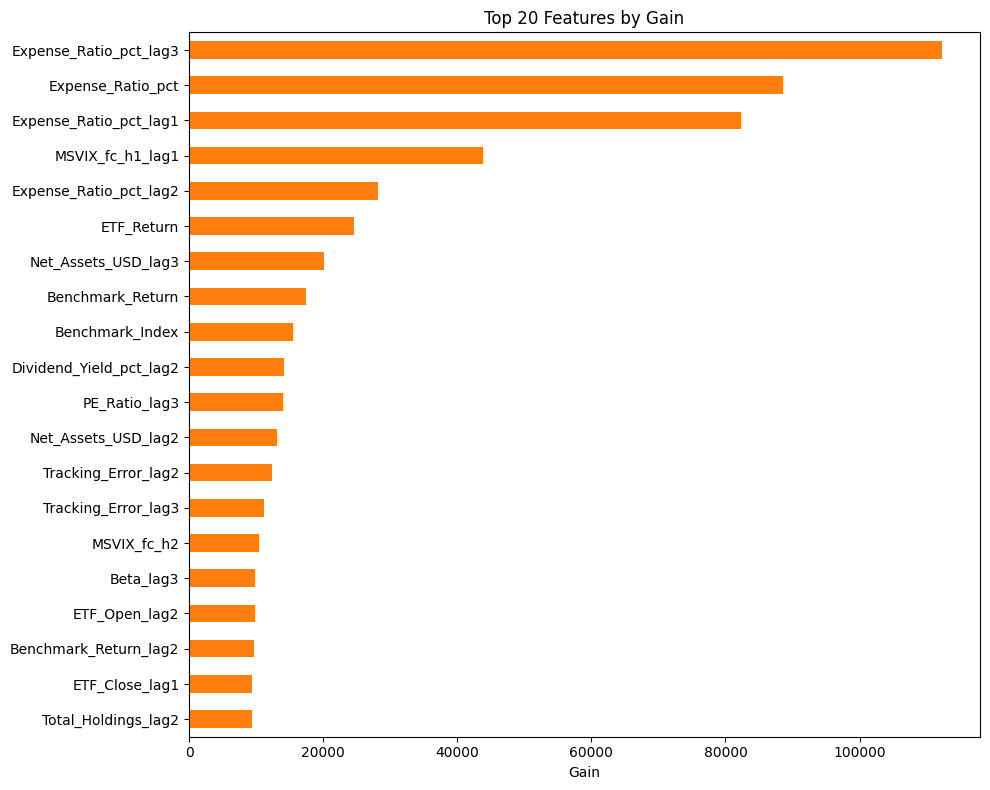

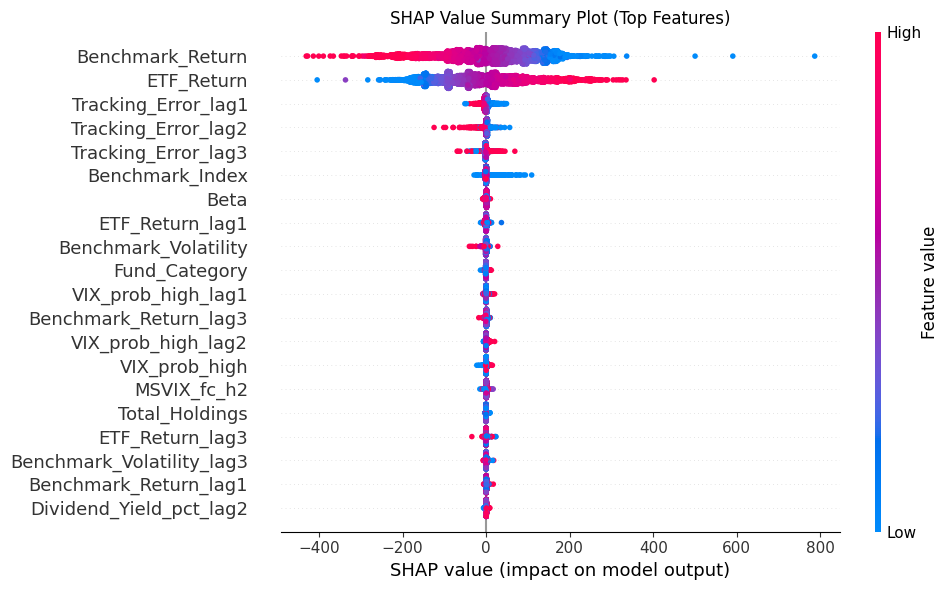

,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,2.899630,1.974953,12.308296,11.453269,0.896877
IDU,21.183462,3.796943,463.155819,160.864780,0.020041
IJH,7.909278,3.703699,76.274064,58.587169,0.317950
IJR,10.912081,7.416519,174.078270,161.859321,0.433848
IVV,1.118506,0.659120,1.685494,1.474458,0.930228
IWB,0.655829,0.655822,0.860215,0.860215,0.986041
IWD,5.552921,3.976558,46.647947,44.163028,0.482581
IWF,0.603520,0.409620,0.532025,0.494427,0.944459
IWM,6.000552,4.128863,53.054126,49.550906,0.575541


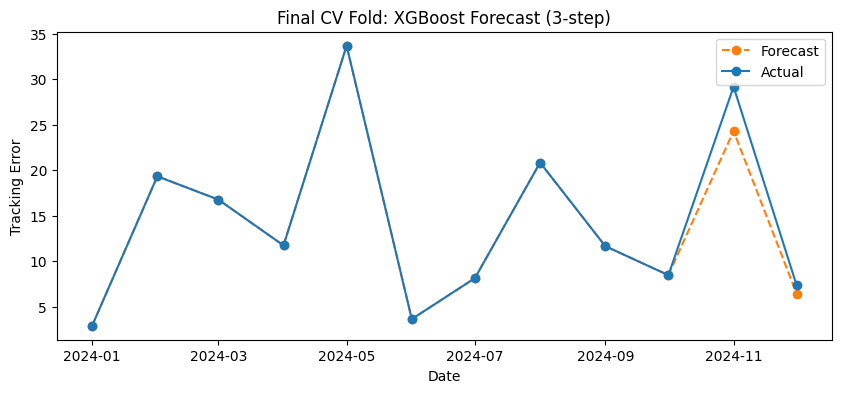

In [185]:
# Run XGBoost with dataset enhanced with MSVIX features
hybrid_results = fit_xgboost(
    etf_data_enriched,               
    horizon=3,
    cv_window=cv_window,
    cv_step=cv_step
)


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,21.397493,2294.990803,0.568273
1,2.000000,15.757376,614.212210,0.719010
2,3.000000,10.675924,365.113675,0.633272
3,4.000000,8.544840,249.702793,0.697276
4,5.000000,28.296686,4953.998827,0.122392
5,6.000000,19.951729,2589.639962,0.586739
6,7.000000,9.770811,264.165464,0.908576


MAE mean ± std : 16.342123 ± 6.739278
MSE mean ± std : 1618.831962 ± 1639.412062
R2 mean ± std : 0.605077 ± 0.223307

=== Learning Curve ===


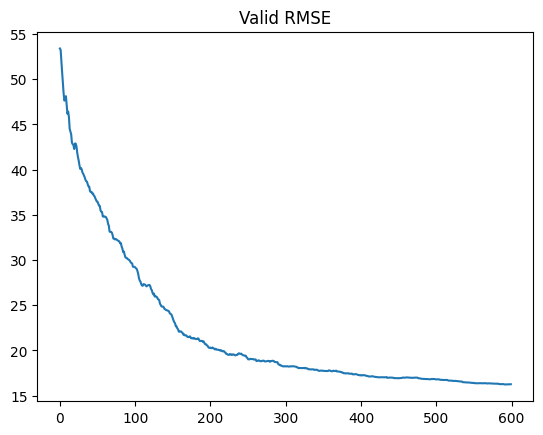

In [186]:
# Display cross-validation results
report_cv(hybrid_results["cv_metrics"])

# Display the learning curve
print("\n=== Learning Curve ===")
plt.plot(hybrid_results["learning_curve"]["valid_rmse"]); plt.title("Valid RMSE"); plt.show()

# Diebold-Mariano Test

### Helper Functions & Set-up

In [187]:
model_order = ["SARIMA_GARCH", "MS_VIX", "XGB", "HYBRID_XGB"]
alpha       = 0.05                    
frames_raw  = {
    "SARIMA_GARCH": sarima_garch_forecast_df,
    "MS_VIX"      : ms_vix_forecast_df,
    "XGB"         : xgboost_results["forecast_df"],
    "HYBRID_XGB"  : hybrid_results["forecast_df"],
}

In [188]:
# 1) DM helper (works for MAE or RMSE/MSE) --------------------------
def dm_test(err_a, err_b, h:int, loss:str="mae"):
    loss = loss.lower()
    if   loss == "mae":  d = np.abs(err_a) - np.abs(err_b)
    elif loss in ("rmse", "mse"): d = err_a**2 - err_b**2
    else: raise ValueError("loss should be 'mae' or 'rmse'")
    T, d_bar = len(d), d.mean()
    q = h - 1
    gamma0 = np.mean((d - d_bar) ** 2)
    gamma  = [np.mean((d[q:] - d_bar) * (d[:-q] - d_bar))
              for q in range(1, q + 1)]
    var_d  = gamma0 + 2 * np.sum(gamma)
    dm     = d_bar / np.sqrt(var_d / T)
    p_val  = 2 * (1 - 0.5*(1 + np.math.erf(abs(dm)/np.sqrt(2))))
    return dm, p_val

# 2) harmonise column names ----------------------------------------
def _std(df):
    df = df.copy()
    if "ETF" in df.columns and "ETF_Ticker" not in df.columns:
        df = df.rename(columns={"ETF": "ETF_Ticker"})
    return df[["Date", "ETF_Ticker", "horizon", "Forecast", "Actual"]]

model_frames = {m: _std(frames_raw[m]) for m in model_order}

# 3) pooled DM for any metric --------------------------------------
from itertools import combinations
def pooled_dm(loss):
    rows = []
    for (a, df_a), (b, df_b) in combinations(model_frames.items(), 2):
        merged = (df_a.merge(df_b,
                             on=["Date","ETF_Ticker","horizon"],
                             suffixes=("_a","_b")).dropna())
        err_a = merged["Actual_a"] - merged["Forecast_a"]
        err_b = merged["Actual_a"] - merged["Forecast_b"]
        dm, p = dm_test(err_a.values, err_b.values,
                        h=int(merged["horizon"].iloc[0]), loss=loss)
        rows.append([a,b,dm,p])
    out = pd.DataFrame(rows, columns=["Model_A","Model_B","DM_stat","p_value"])
    out["Sig?"]   = out["p_value"] < alpha
    out["Winner"] = out.apply(
        lambda r: ("Tie" if not r["Sig?"]
                   else (r["Model_A"] if r["DM_stat"] < 0 else r["Model_B"])), axis=1)
    return out

# 4) helper to create three matrices --------------------------------
def matrices_from(pooled):
    def nice_sig(r):
        w = "Tie" if r["Winner"]=="Tie" else r["Winner"]
        return f"{w} (p={r['p_value']:.3f})"
    g_sig = pd.DataFrame(index=model_order, columns=model_order, dtype=object)
    g_raw = pd.DataFrame(index=model_order, columns=model_order, dtype=object)
    g_dm  = pd.DataFrame(index=model_order, columns=model_order, dtype=object)

    for _, r in pooled.iterrows():
        a, b = r["Model_A"], r["Model_B"]
        # sig label
        lab = nice_sig(r)
        g_sig.loc[a,b] = g_sig.loc[b,a] = lab
        # raw error winner
        df_a, df_b = model_frames[a], model_frames[b]
        merged = (df_a.merge(df_b,
                             on=["Date","ETF_Ticker","horizon"],
                             suffixes=("_a","_b")).dropna())
        mae_a = np.abs(merged["Actual_a"]-merged["Forecast_a"]).mean()
        mae_b = np.abs(merged["Actual_a"]-merged["Forecast_b"]).mean()
        better = a if mae_a < mae_b else b
        g_raw.loc[a,b] = g_raw.loc[b,a] = better
        # dm stat label
        better2 = a if r["DM_stat"] < 0 else b
        g_dm.loc[a,b] = g_dm.loc[b,a] = f"{better2} (DM={r['DM_stat']:+.3f})"

    for g in (g_sig, g_raw, g_dm):
        np.fill_diagonal(g.values, "--")
    return g_sig, g_raw, g_dm

# 5) produce everything for MAE and RMSE ----------------------------
results = {}
for loss in ["mae", "rmse"]:
    pooled = pooled_dm(loss)
    sig, raw, dm = matrices_from(pooled)
    # ranking (significant wins for that loss)
    wins = {m:0 for m in model_order}
    for _, r in pooled.iterrows():
        if r["Sig?"]:
            wins[r["Winner"]] += 1
    rank = pd.Series(wins, name="wins").sort_values(ascending=False).to_frame()
    results[loss] = dict(sig=sig, raw=raw, dm=dm, rank=rank, pooled=pooled)

### DM-Test Results

In [189]:
# Display the results
for loss in ["mae","rmse"]:
    lab = loss.upper()
    print(f"\n=== DM head-to-head ({lab}, α = {alpha}) ===")
    display(results[loss]["sig"])
    print(f"\n=== Lower raw {lab} (no significance) ===")
    display(results[loss]["raw"])
    print(f"\n=== Winner + DM statistic sign ({lab}) ===")
    display(results[loss]["dm"])
    print(f"\n=== Overall ranking by significant {lab} wins ===")
    display(results[loss]["rank"])


=== DM head-to-head (MAE, α = 0.05) ===


,SARIMA_GARCH,MS_VIX,XGB,HYBRID_XGB
SARIMA_GARCH,--,Tie (p=0.233),XGB (p=0.001),HYBRID_XGB (p=0.000)
MS_VIX,Tie (p=0.233),--,XGB (p=0.001),HYBRID_XGB (p=0.000)
XGB,XGB (p=0.001),XGB (p=0.001),--,HYBRID_XGB (p=0.001)
HYBRID_XGB,HYBRID_XGB (p=0.000),HYBRID_XGB (p=0.000),HYBRID_XGB (p=0.001),--



=== Lower raw MAE (no significance) ===


,SARIMA_GARCH,MS_VIX,XGB,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH,XGB,HYBRID_XGB
MS_VIX,SARIMA_GARCH,--,XGB,HYBRID_XGB
XGB,XGB,XGB,--,HYBRID_XGB
HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,--



=== Winner + DM statistic sign (MAE) ===


,SARIMA_GARCH,MS_VIX,XGB,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH (DM=-1.193),XGB (DM=+3.311),HYBRID_XGB (DM=+4.647)
MS_VIX,SARIMA_GARCH (DM=-1.193),--,XGB (DM=+3.191),HYBRID_XGB (DM=+4.126)
XGB,XGB (DM=+3.311),XGB (DM=+3.191),--,HYBRID_XGB (DM=+3.183)
HYBRID_XGB,HYBRID_XGB (DM=+4.647),HYBRID_XGB (DM=+4.126),HYBRID_XGB (DM=+3.183),--



=== Overall ranking by significant MAE wins ===


,wins
HYBRID_XGB,3
XGB,2
SARIMA_GARCH,0
MS_VIX,0



=== DM head-to-head (RMSE, α = 0.05) ===


,SARIMA_GARCH,MS_VIX,XGB,HYBRID_XGB
SARIMA_GARCH,--,Tie (p=0.720),XGB (p=0.003),HYBRID_XGB (p=0.001)
MS_VIX,Tie (p=0.720),--,XGB (p=0.011),HYBRID_XGB (p=0.005)
XGB,XGB (p=0.003),XGB (p=0.011),--,HYBRID_XGB (p=0.032)
HYBRID_XGB,HYBRID_XGB (p=0.001),HYBRID_XGB (p=0.005),HYBRID_XGB (p=0.032),--



=== Lower raw RMSE (no significance) ===


,SARIMA_GARCH,MS_VIX,XGB,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH,XGB,HYBRID_XGB
MS_VIX,SARIMA_GARCH,--,XGB,HYBRID_XGB
XGB,XGB,XGB,--,HYBRID_XGB
HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,HYBRID_XGB,--



=== Winner + DM statistic sign (RMSE) ===


,SARIMA_GARCH,MS_VIX,XGB,HYBRID_XGB
SARIMA_GARCH,--,SARIMA_GARCH (DM=-0.359),XGB (DM=+2.993),HYBRID_XGB (DM=+3.334)
MS_VIX,SARIMA_GARCH (DM=-0.359),--,XGB (DM=+2.550),HYBRID_XGB (DM=+2.825)
XGB,XGB (DM=+2.993),XGB (DM=+2.550),--,HYBRID_XGB (DM=+2.143)
HYBRID_XGB,HYBRID_XGB (DM=+3.334),HYBRID_XGB (DM=+2.825),HYBRID_XGB (DM=+2.143),--



=== Overall ranking by significant RMSE wins ===


,wins
HYBRID_XGB,3
XGB,2
SARIMA_GARCH,0
MS_VIX,0
